In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   1.119762  0.290496 -0.756272  0.126361 -0.078417 -0.259307 -0.365819   
  1  -0.347401 -1.303843 -1.221000 -0.868303  1.351097 -0.264934  0.911703   
  2   1.026871 -0.471129  0.252670  0.516644  0.811493  0.064877 -0.295466   
  3   0.074179  0.716426  0.263514  0.006600  0.406210  0.178635 -0.802164   
  4  -0.098748  0.137647  0.140623  0.251948 -0.194668  0.081368  0.069937   
  5  -0.694934 -1.208326  0.313268  0.142715 -0.279487  0.539807  0.933857   
  6   1.237979  0.337146 -0.090634  0.443511  0.713129  0.050955 -0.309434   
  7   0.223683  0.624989 -0.208222 -1.064183 -0.137094 -0.239154 -0.677726   
  8   0.049933 -0.356218  0.288273  0.620206  1.743490  0.528331 -0.415359   
  9   1.419609 -0.036003 -1.071239 -1.114557  0.210083 -0.400379 -0.583166   
  10  1.571293  0.637638  0.620707  0.113148  0.332840 -0.166032  0.037380   
  11  0.380843 -0.408241 -0.041281 -0.749904  0.630631  0.766583 -0.235589   
  12 -0.008480 -0.266585 -0.013519  1.260674 -0.037279 -0.225273 -0.516291   
  13  0.196158  0.630249 -0.165683  0.526823  0.601660 -0.424035  0.977182   
  14  0.265570 -0.176036 -0.216730  1.047002  0.092421 -0.201449  1.084307   
  15 -0.385908 -0.412518 -0.695612  0.043059 -0.212036  0.043655 -0.131966   
  16  0.791664  0.365735  0.390475  0.111358  0.665322 -0.323124 -0.173052   
  17  0.452149  0.035214 -0.813169 -0.125926  0.646239  0.369169  0.518338   
  18 -0.824256  0.021422  0.173285 -0.929554  0.607249 -0.233937  0.773526   
  19  0.420225  0.142592 -0.427138 -0.315567  0.990048 -0.445510 -0.525020   
  20  0.090233  0.570817  0.408532  0.114006 -0.192590 -0.267702  0.238375   
  21  0.451080 -0.394344 -0.063828  0.116019 -0.211652  0.765768  0.467992   
  22  0.108582  0.080072 -0.402069 -0.463130  0.480230  0.523257 -0.625964   
  23 -0.745909  0.040926  0.337732  0.401772  0.967712  0.212474 -0.170000   
  24 -0.845368 -0.254540 -0.377679 -0.386857  0.298489 -0.481406 -0.356988   
1 0  -0.237455  0.287082 -0.257738 -0.197896 -0.227543 -0.692510 -0.030253   
  1   0.245057 -0.659527  0.362866 -0.184844  0.743813  0.057505 -0.558147   
  2   0.299641 -0.237578  0.428306  0.868339  0.163360 -0.552186 -0.324194   
  3   0.063897  0.663467  0.223370  0.190253 -0.362876  1.250108 -1.004049   
  4  -0.165897  0.562634 -0.191408 -0.442585 -0.786806  0.155577  0.108388   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.713060 -0.206684  0.699910  ...  0.192863  0.540638 -0.488134   
  1  -0.580570  0.536779  0.697181  ... -0.644330 -0.581767 -0.926250   
  2   0.360842  0.054984  0.099145  ... -0.938572 -0.589866  0.066350   
  3   0.546567  1.376372  0.233428  ... -0.220750 -0.668838 -0.046170   
  4  -0.531183  0.698000  0.679399  ... -0.826442 -0.570135 -0.178045   
  5  -0.069659  0.442903  0.700088  ... -0.998966  0.307642  0.054722   
  6  -1.082152  0.282297  0.713462  ... -0.351754 -0.467059 -1.474990   
  7  -1.492160 -0.763370  0.116687  ... -0.952621  0.037801 -0.416093   
  8  -0.336574 -0.322189  0.261194  ... -0.233592 -0.359333  0.479045   
  9   0.370195  0.759820  0.790840  ...  0.717523  0.001104 -0.458547   
  10 -0.492492 -0.248669  0.070220  ...  0.369986  0.054729 -0.095104   
  11  0.357271  0.616125  0.522243  ... -1.579243  0.643433  0.088542   
  12 -0.554672  0.961433  1.409331  ... -1.112113 -0.474830 -0.444986   
  13  1.231567  0.955260  1.457472  ...  0.051543 -0.128096  0.017568   
  14 -0.743354 -0.036828  0.006548  ... -0.671960 -0.419230  0.122565   
  15  0.301190  0.573755  1.457918  ... -0.986569 -0.344683 -1.153591   
  16 -0.788893 -0.168399  0.277421  ... -0.670183 -0.582366  0.238427   
  17  0.636261  0.685777  0.418994  ... -0.377596  0.480040  0.428413   
  18  0.849892  0.605524  0.474572  ... -0.226022  0.879233 -0.028448   
  19  0.501235  0.629657  0.277576  ... -1.515732 -0.764097 -0.639704   
  20  0.508324  0.592128  0.581461  ...  0.167558 -0.569186 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.173747  0.042521  27.603737  1.003508e-167  1.090407  1.257087


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



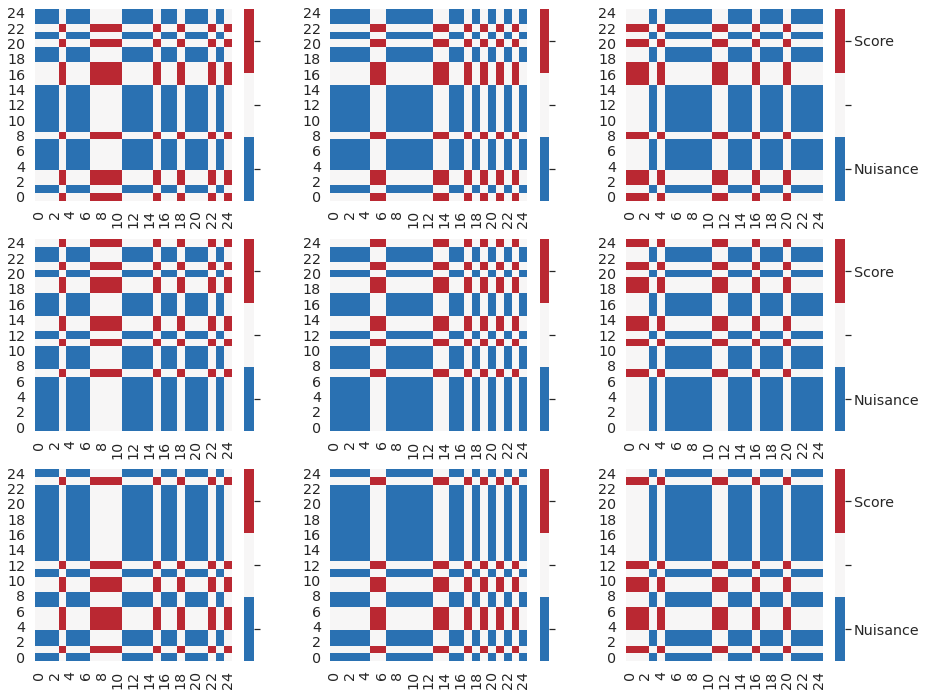

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



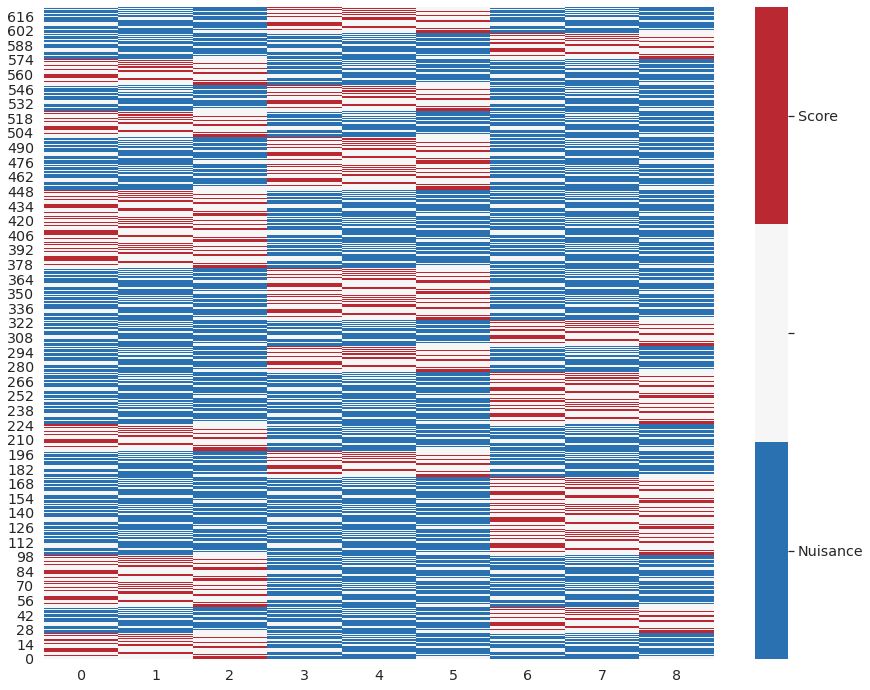

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])